Outlier predictions: 438
Inlier predictions: 113062
Outlier actuals: 425
Inlier actuals: 113075
Accuracy score: 99.989%
F1 score: 0.985
Time taken: 9.552546739578247


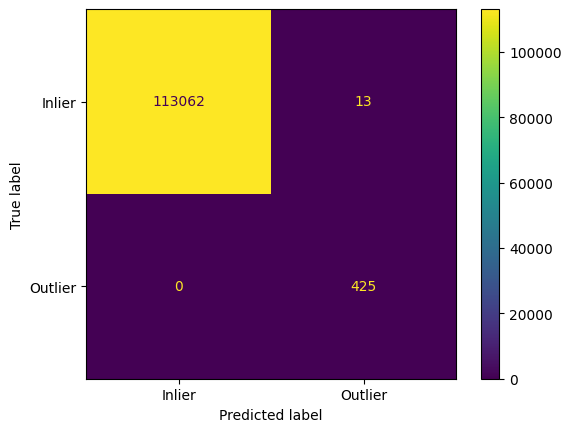

In [124]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import time

#Hyperparameters#
N_NEIGHBORS = 100
LOCAL_OUTLIER_FACTOR_THRESHOLD = 4
#################

class LocalOutlierFactor:
    def __init__(self, n_neighbors=N_NEIGHBORS,local_outlier_factor_threshold = LOCAL_OUTLIER_FACTOR_THRESHOLD, eps = 1E-30):
        self.n_neighbors = n_neighbors
        self.local_outlier_factor_threshold = local_outlier_factor_threshold
        self.eps = eps
        self.neighbors = NearestNeighbors(n_neighbors=self.n_neighbors)
    
    def fit(self, train_oneclassdata):
        self.train_oneclassdata = np.unique(train_oneclassdata, axis=0)
        self.neighbors.fit(self.train_oneclassdata)
        self.k_distance_list = self.k_distance_and_indices(self.train_oneclassdata)[0][:,-1]
        self.neighborhood_density_list = self.calculate_neighborhood_density(self.train_oneclassdata)
        return self
    
    def k_distance_and_indices(self, X):
        distances, indices = self.neighbors.kneighbors(X)
        return distances, indices
    
    def calculate_neighborhood_density(self,X):
        k_distances, k_nearest_neighbours = self.k_distance_and_indices(X)
        k_d_reach =  np.maximum(k_distances,self.k_distance_list[k_nearest_neighbours])
        neighborhood_density = (self.n_neighbors * 1.0)/(np.sum(k_d_reach,axis=-1)+self.eps)        
        return neighborhood_density
    
    def calculate_local_outlier_factor(self, X):
        neighbors = self.k_distance_and_indices(X)[1]
        neighborhood_density = self.calculate_neighborhood_density(X)
        localOutlierFactor = np.mean(self.neighborhood_density_list[neighbors],axis=-1)/neighborhood_density
        return localOutlierFactor
        
    def predict(self,X):
        return self.calculate_local_outlier_factor(X) > self.local_outlier_factor_threshold
    
        
if __name__ == '__main__':
    df = pd.read_csv('http.csv')
    time_start = time.time()   
    trainx, testx, trainy, testy = train_test_split(df.drop(['attack'], axis=1).values, df['attack'].values, test_size=0.2)
    localOutlierFactorClassifier = LocalOutlierFactor().fit(trainx[trainy == 0])
    
    #prediction
    testy_pred = localOutlierFactorClassifier.predict(testx)
    
    #show confusion matrix to check directional accuracy
    cm = confusion_matrix(testy>0, testy_pred>0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Inlier','Outlier'])
    disp.plot()
    print("Outlier predictions:",np.sum(testy_pred>0))
    print("Inlier predictions:",np.sum(testy_pred<=0))
    print("Outlier actuals:",np.sum(testy>0))
    print("Inlier actuals:",np.sum(testy<=0))
    print(f'Accuracy score: {accuracy_score(testy>0, testy_pred>0) :>.3%}')
    print(f'F1 score: {f1_score(testy>0, testy_pred>0) :>.3}')
    time_end = time.time()
    print("Time taken:",time_end-time_start)
    plt.show()
    